In [269]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.stats
import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_1samp_test
import gc
import os
import copy
import pickle
from os.path import exists
import mne
import numpy as np
from mne import create_info
from IPython.utils import io
import yasa
import seaborn as sns
import pandas as pd
import matlab
import matlab.engine
import os
import shutil
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.signal import freqz
from scipy import signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(a, b):
    return a[1] >= b[0] and a[0] <= b[1]

def restart_output_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

gc.collect()

Nothing done.


32

In [270]:
pkl_dir = "C:\\Users\\User\\Cloud-Drive\\BigFiles\\OmissionExpOutput\\eventDetection\\imported_eventDetectionChan"
import_type = "eventDetectionChan"
event_detection_dir_name = 'eventDetection'
import_path = f'{pkl_dir}\\{import_type}.pkl'

In [271]:
with open(import_path, "rb") as file:  [allsubsdata_perFile, configu] = pickle.load(file)

main_output_dir = f"{configu['outputs_dir_path']}\\{event_detection_dir_name}"
edf_output_dir = f"{main_output_dir}\\EDFViewFormat_events"
manual_detection_dir = f"{edf_output_dir}\\manual_annotation"
if not os.path.exists(main_output_dir): os.mkdir(main_output_dir)
if not os.path.exists(edf_output_dir): os.mkdir(edf_output_dir)


edfviewFormatSuffix = 'efdViewFormat'
multiElectd_text = "multiElectd"
singleElectd_text = "singleElectd"
scoring_edfViewFormat_key = f'scoring_{edfviewFormatSuffix}'
electrode_column_name = 'electrode'
header = np.array(['Onset',"Duration","Annotation"])

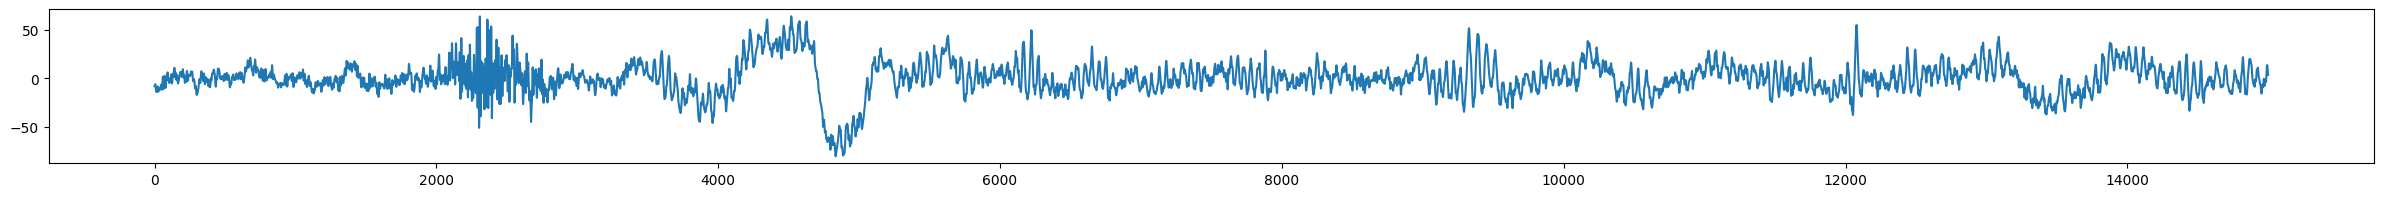

In [272]:
curr_electrode_num = np.where(configu['electrodes_names'] == 'C3')[0][0]
data = allsubsdata_perFile['32_2']['data'][curr_electrode_num]

epochnum = 4
epochstart = 30 * configu['sample_freq'] * epochnum
epochEnd = epochstart + 30*configu['sample_freq']

# plt.plot(data[324930-100:100+325175])
plt.plot(data[epochstart:epochEnd])
plt.rcParams["figure.figsize"] = (30,2)
plt.show()

In [273]:
## RUN THIS TO GET COMPARISONS OF SPINDLES MINMANX_SD OPTIONS
run_comparison_of_spindle_minMax = False

## RUN this to get scoring events files only
run_scoring_eventFiles = False

## RUN THIS TO GET AN_SlowWaves events
run_comparison_of_sw_minMax = False

run_kcomp_shaYKM = True
run_kcomp_shaYKM_comparison = True

testType = 1
if(testType==1):
    file_ids = ['32_2']
    minMax_sd_vers = [[4,10,1]]
    electrodes_names_detect = ['Fp2','F3']
    electrodes_names_detect =  ['Fp2','F3']
    electrodes_names_detect = ['Fp2','F3']
elif(testType==2):
    file_ids = ['32_2','38_2']
    minMax_sd_vers = [[3,9,1],[4,10,1]]
    electrodes_names_detect = ['Fp2','F3']
    electrodes_names_detect =  ['Fp2','F3']
    electrodes_names_detect = ['Fp2','F3']
elif(testType==3):
    file_ids = ['32_2','38_2']
    minMax_sd_vers = [[3,9,1],[4,10,1]]
    electrodes_names_detect = ['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2']
elif(testType==4):
    file_ids = ['32_2','38_2']
    electrodes_names_detect =  ['Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','Cz']
    minMax_sd_vers = [[3,8,1],[4,8,1],[3,9,1],[4,9,1],[3,10,1],[4,10,1]]
else:
    file_ids = allsubsdata_perFile.keys()
    electrodes_names_detect = configu['electrodes_names']
    minMax_sd_vers = [[3,8,1],[4,8,1],[3,9,1],[4,9,1],[3,10,1],[4,10,1]]


In [274]:
def filter_sleep_stages(file_ids,event_key_to_use,after_sleepStage_exclution_key, sleepstages):
    for id in file_ids:
        if event_key_to_use not in allsubsdata_perFile[id]: continue
        event_allElectrodes = allsubsdata_perFile[id][event_key_to_use]
        
        event_filtered_sleepstages = pd.DataFrame([], columns=event_allElectrodes.columns)
        for sleepstage in sleepstages:
            event_filtered_sleepstages = pd.concat([event_filtered_sleepstages , event_allElectrodes.loc[(event_allElectrodes['currentStage'] == sleepstage)]])

        if len(event_filtered_sleepstages) == 0:  print(f"sub:{id} - no events in sleepstages{sleepstages}")
        else: print(f"sub:{id}, before exclude sleep stages:{len(event_allElectrodes)}, after:{len(event_filtered_sleepstages)}")
        
        allsubsdata_perFile[id][after_sleepStage_exclution_key] = event_filtered_sleepstages

def edfViewFormat_scoring_dict(score):
    if score == 0:
        return 'W'
    elif score ==1:
        return 'N1'
    elif score ==2:
        return 'N2'
    elif score ==3:
        return 'N3'
    elif score ==4:
        return 'TREM'
    elif score ==5:
        return 'PREM'
    elif score ==6:
        return 'MOVE'
    elif score ==7:
        return 'ARTIFACT'
    else:
        Exception('no such score')
def add_edfViewFormat_scoring(key_edfScoringFormat):
    for id in allsubsdata_perFile:
        curr_file_scoring = allsubsdata_perFile[id]['scoring']
        new_format_score = np.zeros((len(curr_file_scoring),3), dtype=object)
        for ind, score in enumerate(curr_file_scoring):
                new_format_score[ind,:] = [30*ind,30,edfViewFormat_scoring_dict(score)] ## onset (sec), duration, desc

        allsubsdata_perFile[id][key_edfScoringFormat] = new_format_score

# Save events (scoring and ss) per file, in a format suitable for EDF_viewer
def save_eventsAllTogether_edfViewFormat(events_types_for_save,edfViewFormat_output_dir):
        for id in file_ids:
            filename = f"{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_events"
            all_events_with_header = np.asarray([header],dtype=object)
            for event_type in events_types_for_save:
                events_type_found = [ v for k, v in allsubsdata_perFile[id].items() if (event_type in k) and (edfviewFormatSuffix in k)]
                if np.size(events_type_found) == 0: continue
                for events_found in events_type_found:
                        for event_found in events_found:
                                all_events_with_header = np.concatenate((all_events_with_header,[event_found]),dtype=object)
            np.savetxt(f"{edfViewFormat_output_dir}\\allEvents_{filename}.txt", all_events_with_header, delimiter='\t',fmt='%s')

In [275]:
if(run_scoring_eventFiles):
    edfViewFormat_onlyScoring_output_dir = f'{edf_output_dir}\\only_scoring'
    restart_output_dir(edfViewFormat_onlyScoring_output_dir)

    add_edfViewFormat_scoring(scoring_edfViewFormat_key)

    events_types_to_save = ['scoring']    
    save_eventsAllTogether_edfViewFormat(events_types_to_save,edfViewFormat_onlyScoring_output_dir)  

In [276]:
def detect_ss_AndrillonNir(file_ids,minMax_sd_ver,output_key,electrodes_names):
    andriNir_code_dir = os.getcwd()
    andriNir_output_dir = f"{configu['outputs_dir_path']}\\{main_dir_name}\\Andrillon_Nir"
    andriNir_aux_output_dir = f"{andriNir_output_dir}\\aux_mats"

    if os.path.exists(andriNir_output_dir):
        shutil.rmtree(andriNir_output_dir)
    os.mkdir(andriNir_output_dir)
    os.mkdir(andriNir_aux_output_dir)

    spindles_output_columns =  ['spindleStartTime', 'spindleEndTime', 'peakTime', 'peakEnergy', 'peakEnergyNorm', 'freqSpindle', 'spindleDuration/SR', 'PowerSP', 'PowerAlpha', 'currentStage']

    for id in file_ids:
        datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
        datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)
        scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_data, sf_data=configu['sample_freq'], verbose=True)
        ss_allElectrodes = pd.DataFrame()

        for electd_i, electrode_name_eventDetect in enumerate(electrodes_names):
            curr_electrode_num = np.where(configu['electrodes_names'] == electrode_name_eventDetect)[0][0]

            ## create aux files to use in MATLAB
            datafile_1elect_eeg = datafile_data[curr_electrode_num,:]
            if 2 not in datafile_scoring or 3 not in datafile_scoring:
                continue
            
            DetectionThreshold = minMax_sd_ver[0]
            RejectThreshold = minMax_sd_ver[1]
            StartEndThreshold = minMax_sd_ver[2]
            mat_to_save = {'datafile_data': datafile_1elect_eeg, 'scoring_upsampled': scoring_upsampled, 'sample_freq': configu['sample_freq'], 'electrode_name':electrode_name_eventDetect, 'DetectionThreshold':DetectionThreshold,'RejectThreshold':RejectThreshold, 'StartEndThreshold':StartEndThreshold}
            scipy.io.savemat(f"{andriNir_aux_output_dir}\\{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_{electrode_name_eventDetect}AndScoring.mat",mat_to_save)

            ## run Andrillon & Nir SS detection over all subjects files
            eng = matlab.engine.start_matlab()
            eng.cd(andriNir_code_dir, nargout=0)
            out = eng.batch_useAndrillonNirSSDetection(andriNir_aux_output_dir, andriNir_output_dir,nargout=0)
            eng.quit()

            ## add the spindles data to the main subject dictionary
            try: 
                spindles_file_name = f"{andriNir_output_dir}\\SS_AN_{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_{electrode_name_eventDetect}AndScoring.mat"
                matlabImport = scipy.io.loadmat(spindles_file_name, simplify_cells=True)
            except Exception: 
                print(f"Error importing spindles sub file at: {allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}")
                continue

            ss = matlabImport['spindles']
            if np.size(np.shape(ss)) == 1: 
                temp = np.zeros((1,np.size(ss)),dtype=object)
                temp[0] = ss
                ss = temp
            if np.size(ss) >0 :
                df = pd.DataFrame(np.double(ss))
                df.columns = spindles_output_columns
                tile_electrode = np.tile(f"{electrode_name_eventDetect}", ss.shape[0])[None].T
                df[electrode_column_name] = tile_electrode
                
                allsubsdata_perFile[id][f'{output_key}@@{electrode_name_eventDetect}'] = df
                if electd_i ==0: ss_allElectrodes =  df
                else:  ss_allElectrodes = pd.concat([ss_allElectrodes,df])
    
        if not ss_allElectrodes.empty:
            allsubsdata_perFile[id][output_key]  = ss_allElectrodes

    minmax_sd_name =  matlabImport['minMax_SD_threshold']
    shutil.rmtree(andriNir_aux_output_dir)
    return minmax_sd_name
def group_spindles(ss_key_to_use, uniqeElctds_ss_key, uniqeElctd_ss_key):
    # The grouping is done such that you get 1 event per time frame.
    # In the single condition, only one electrode is sufficiant to include event.
    #  In the multi condition event will be includede only if it appears in sevral electrodes
    # The picked electrode is the one where the event is with the most power
    for id in allsubsdata_perFile:
        if ss_key_to_use not in allsubsdata_perFile[id]:  continue
        filterd_events_allElectrodes = allsubsdata_perFile[id][ss_key_to_use].copy(deep=True)
        
        filterd_events_allElectrodes.sort_values(by=['spindleStartTime'],inplace=True) 
        filterd_events_allElectrodes.reset_index(drop=True, inplace=True)
        deleted = filterd_events_allElectrodes.copy(deep=True)
        filtered = pd.DataFrame([], columns = deleted.columns)
        filtered_moreThan1 = pd.DataFrame([], columns = deleted.columns)
        simultan = pd.DataFrame([], columns = deleted.columns)

        while len(deleted)>0:
            if len(simultan)==0:
                simultan = pd.concat([simultan, deleted.iloc[[0]]])
                deleted.drop(deleted.index[0], axis=0, inplace=True)
                still_overlap = True
            else:
                while still_overlap == True and len(deleted)>0:
                    still_overlap = False
                    simultan.reset_index(drop=True, inplace=True) # make sure indexes pair with number of rows

                    ## check now_overlap_all_in_simultan:
                    for index, simultan_row in simultan.iterrows():
                        simultan_0 = simultan_row['spindleStartTime']
                        simultan_1 = simultan_row['spindleEndTime']
                        deleted_0 = deleted.iloc[0]['spindleStartTime']
                        deleted_1 = deleted.iloc[0]['spindleEndTime']
                        if overlap([simultan_0,simultan_1],[deleted_0,deleted_1]):
                            simultan = pd.concat([simultan, deleted.iloc[[0]]])
                            deleted.drop(deleted.index[0], axis=0, inplace=True)
                            still_overlap = True
                            break
                    if still_overlap: continue
                    else:
                        ## check max ps and add to filt
                        # if len(simultan)>1:
                        #     print('hu')
                        simultan.sort_values(by=['PowerSP'],ascending=False,inplace=True)
                        row_df = simultan.iloc[[0]]
                        row_df.iat[0, row_df.columns.get_loc(electrode_column_name)] = np.array(simultan[electrode_column_name])
                        filtered = pd.concat([filtered,row_df])
                        if len(simultan) > 1: filtered_moreThan1 = pd.concat([filtered_moreThan1,row_df])
                        simultan = pd.DataFrame([], columns = deleted.columns)                    
            
        filtered.reset_index(drop=True, inplace=True) # make sure indexes pair with number of rows
        filtered_moreThan1.reset_index(drop=True, inplace=True) # make sure indexes pair with number of rows
        allsubsdata_perFile[id][uniqeElctd_ss_key] = filtered   
        allsubsdata_perFile[id][uniqeElctds_ss_key] = filtered_moreThan1   
        print(f"sub:{id}, before filt:{np.shape(allsubsdata_perFile[id][ss_key_to_use])[0]}, after:{np.shape(allsubsdata_perFile[id][uniqeElctd_ss_key])[0]}, after>1: after:{np.shape(allsubsdata_perFile[id][uniqeElctds_ss_key])[0]}")

## not good.
def add_edfViewFormat_ss(file_ids,event_key_for_save, SS_efdViewFormat_key):
    # if event_key_for_save not in allsubsdata_perFile[id]:
    #         #print(f"no {event_key_for_save} for sub {id}")
    #         continue
    kcomp_df = allsubsdata_perFile[id][event_key_for_save]

    startTime_arr = np.array(kcomp_df['wavest'])
    endTime_arr = np.array(kcomp_df['wavend'])
    duration_arr = np.round(endTime_arr - startTime_arr,2)
    electd_arr_per_sw = np.array(kcomp_df[electrode_column_name])
    desc = [f"kcomp@@{electd_arr}" for electd_arr in electd_arr_per_sw]
    new_format_kcomp = np.array([startTime_arr ,duration_arr,desc]).T ## onset (sec), duration,desc

    allsubsdata_perFile[id][kcomp_efdViewFormat_key] = new_format_kcomp

def save_eventsSepratelyForComparison_edfViewFormat(file_ids,events_types_to_compare,edfViewFormat_output_dir):
    # Save events (scoring and ss) per file, in a format suitable for EDF_viewer
    for id in file_ids:
        for event_type in events_types_to_compare:
            filename = f"{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_events"
            all_events_with_header = np.asarray([header],dtype=object)
            events_type_found = [ v for k, v in allsubsdata_perFile[id].items() if ((event_type in k) and (edfviewFormatSuffix in k))]
            if np.size(events_type_found) == 0: continue
            for events_found in events_type_found:
                    for event_found in events_found:
                            all_events_with_header = np.concatenate((all_events_with_header,[event_found]),dtype=object)
            np.savetxt(f"{edfViewFormat_output_dir}\\{event_type}_{filename}.txt", all_events_with_header, delimiter='\t',fmt='%s')
 
if(run_comparison_of_spindle_minMax):
    edfViewFormat_minMaxSSTests_output_dir = f'{edf_output_dir}\\minmax_sd_tests'
    restart_output_dir(edfViewFormat_minMaxSSTests_output_dir)

    for minMax_sd_ver in minMax_sd_vers:        
        all_electodes_ss_key = 'SS_AN'
        minmax_sd_name = detect_ss_AndrillonNir(file_ids,minMax_sd_ver,all_electodes_ss_key,electrodes_names_detect)
        print(minmax_sd_name)

        after_sleepStage_exclution_key = f"{all_electodes_ss_key}_n2n3"
        filter_sleep_stages(file_ids,all_electodes_ss_key,after_sleepStage_exclution_key, [2.0,3.0]) 

        ss_key_to_use = after_sleepStage_exclution_key
        multiElectdPerSS_key = f"{ss_key_to_use}_{multiElectd_text}"
        singleElectdPerSS_key = f"{ss_key_to_use}_{singleElectd_text}"
        group_spindles(ss_key_to_use,multiElectdPerSS_key, singleElectdPerSS_key)

        SS_multiElectdPerSS_efdViewFormat_key = f'{multiElectdPerSS_key}_{edfviewFormatSuffix}'
        SS_singleElectdPerSS_efdViewFormat_key = f'{singleElectdPerSS_key}_{edfviewFormatSuffix}'
        add_edfViewFormat_ss(file_ids,multiElectdPerSS_key,SS_multiElectdPerSS_efdViewFormat_key)
        add_edfViewFormat_ss(file_ids,singleElectdPerSS_key,SS_singleElectdPerSS_efdViewFormat_key)

        events_types_to_compare = [multiElectd_text,singleElectd_text]    
        edfViewFormat_eventsTest_output_dir = f"{edfViewFormat_minMaxSSTests_output_dir}\\{minMax_sd_ver}"
        restart_output_dir(edfViewFormat_eventsTest_output_dir)
        save_eventsSepratelyForComparison_edfViewFormat(file_ids,events_types_to_compare,edfViewFormat_eventsTest_output_dir)

        add_edfViewFormat_scoring(scoring_edfViewFormat_key)

        events_types_to_save = ['scoring', multiElectd_text,singleElectd_text]    
        save_eventsAllTogether_edfViewFormat(events_types_to_save,edfViewFormat_eventsTest_output_dir)

In [277]:
def preform_minmaxSD_comparison(events_types_to_compare,file_ids,minMax_sd_vers):
    all_comparisons = pd.DataFrame(columns=['id','eventType','minmax_ver','Positive','TruePos','FalsePos', 'hitRate','falseDiscoveryRate'])
    for id in file_ids:
        for ver in minMax_sd_vers:
            for event_type in events_types_to_compare:
                dir_auto_ = f"{edfViewFormat_minMaxSSTests_output_dir}\\{ver}"
                manual_detection_filename = f"{manual_detection_dir}\\{id}_imported_manual-ss.txt"
                auto_detection_filename = f"{dir_auto_}\\{event_type}_{id}_events.txt"
                ## get the array of before manual scanning
                if os.path.exists(auto_detection_filename) and os.path.exists(manual_detection_filename):
                    all_ss_auto = np.loadtxt(auto_detection_filename, delimiter="\t",dtype='object')
                    all_ss_auto = np.delete(all_ss_auto, np.where(all_ss_auto[:, 2] == "Annotation")[0], axis=0)
                    all_ss_auto[:,[0,1]] = [np.double(x) for x in all_ss_auto[:,[0,1]]]
                    ss_ind = np.array([],dtype=int)
                    for ind_i, desc in enumerate(all_ss_auto[:,2]):
                        if ("SS" in desc) or ("ss" in desc):
                            ss_ind = np.append(ss_ind, ind_i)
                    all_ss_auto = all_ss_auto[ss_ind,:]

                    ## get the array of after manual scanning
                    all_ss_manu = np.loadtxt(manual_detection_filename, delimiter="\t",dtype='object')
                    all_ss_manu = np.delete(all_ss_manu, np.where(all_ss_manu[:, 2] == "Annotation")[0], axis=0)
                    all_ss_manu[:,[0,1]] = [np.double(x) for x in all_ss_manu[:,[0,1]]]
                    ss_ind = np.array([],dtype=int)
                    for ind_i, desc in enumerate(all_ss_manu[:,2]):
                        if "SS" in desc:
                            ss_ind = np.append(ss_ind, ind_i)
                    all_ss_manu = all_ss_manu[ss_ind,:]

                    ## compare to find rate od TP and FP
                    TP = 0
                    FP = 0
                    for ss_auto in all_ss_auto:
                        found = False
                        for ss_manu in all_ss_manu:
                            if overlap([ss_auto[0],ss_auto[0]+ss_auto[1]],[ss_manu[0],ss_manu[0]+ss_manu[1]]):
                                TP +=1
                                found = True
                                break
                        if found == False:
                            FP +=1

                    # FN = 0
                    # for ss_manu in all_ss_manu:
                    #     found = False
                    #     for ss_auto in all_ss_auto:
                    #         if overlap([ss_auto[0],ss_auto[0]+ss_auto[1]],[ss_manu[0],ss_manu[0]+ss_manu[1]]):
                    #             found = True
                    #             break
                    #     if found == False:
                    #         FN +=1

                    Positive = np.shape(all_ss_manu)[0]   
                    hitRate = TP/Positive
                    #missRate = FN/Positive
                    falseDiscoveryRate = FP/(FP+TP)
                    
                    comparison = [id,event_type, ver, Positive, TP, FP,hitRate, falseDiscoveryRate]
                    all_comparisons.loc[len(all_comparisons)] = comparison

    all_comparisons = all_comparisons.sort_values('minmax_ver')
    all_comparisons = all_comparisons.sort_values('id')
    return all_comparisons
if(run_comparison_of_spindle_minMax):
    events_types_to_compare = [multiElectd_text,singleElectd_text]
    all_comp = preform_minmaxSD_comparison(events_types_to_compare,file_ids,minMax_sd_vers)
    # all_comp.to_csv('ss_comparisons.csv',index=False)
    display(all_comp)

In [278]:
def detect_sw_AndrillonNir(file_ids,output_key,electrodes_names):
    andriNir_code_dir = os.getcwd()
    andriNir_output_dir = f"{configu['outputs_dir_path']}\\{main_dir_name}\\Andrillon_Nir"
    andriNir_aux_output_dir = f"{andriNir_output_dir}\\aux_mats"

    if os.path.exists(andriNir_output_dir):
        shutil.rmtree(andriNir_output_dir)
    os.mkdir(andriNir_output_dir)
    os.mkdir(andriNir_aux_output_dir)

    sw_output_columns = ['wavest' ,'wavend', 'mdpt', 'poszx', 'period/SR' ,'abs(b)', 'bx', 'c' ,'cx' ,'maxb2c', 'n1', 'n1x', 'nEnd', 'nEndx' ,'p1', 'p1x' ,'meanAmp', 'nump', 'nperiod/SR', 'p2p', 'mxdn', 'mxup' ,'currentStage']

    for id in file_ids:
        datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
        datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)
        scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_data, sf_data=configu['sample_freq'], verbose=True)
        sw_allElectrodes = pd.DataFrame()

        for electd_i, electrode_name_eventDetect in enumerate(electrodes_names):
            curr_electrode_num = np.where(configu['electrodes_names'] == electrode_name_eventDetect)[0][0]

            ## create aux files to use in MATLAB
            datafile_1elect_eeg = datafile_data[curr_electrode_num,:]
            if 2 not in datafile_scoring or 3 not in datafile_scoring:
                continue
            
            mat_to_save = {'datafile_data': datafile_1elect_eeg, 'scoring_upsampled': scoring_upsampled, 'sample_freq': configu['sample_freq'], 'electrode_name':electrode_name_eventDetect}
            scipy.io.savemat(f"{andriNir_aux_output_dir}\\{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_{electrode_name_eventDetect}AndScoring.mat",mat_to_save)

            ## run Andrillon & Nir SW detection over all subjects files
            eng = matlab.engine.start_matlab()
            eng.cd(andriNir_code_dir, nargout=0)
            out = eng.batch_useAndrillonNirSWDetection(andriNir_aux_output_dir, andriNir_output_dir,nargout=0)
            eng.quit()

            ## add the SW data to the main subject dictionary
            try: 
                sw_file_name = f"{andriNir_output_dir}\\{output_key}_{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_{electrode_name_eventDetect}AndScoring.mat"
                matlabImport = scipy.io.loadmat(sw_file_name, simplify_cells=True)
            except Exception: 
                print(f"Error importing spindles sub file at: {allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}")
                continue

            sw = matlabImport['allWaves']
            if np.size(np.shape(sw)) == 1: 
                temp = np.zeros((1,np.size(sw)),dtype=object)
                temp[0] = sw
                sw = temp
            if np.size(sw) >0 :
                df = pd.DataFrame(np.double(sw))
                df.columns = sw_output_columns
                tile_electrode = np.tile(f"{electrode_name_eventDetect}", sw.shape[0])[None].T
                df[electrode_column_name] = tile_electrode
                
                allsubsdata_perFile[id][f"{output_key}@@{electrode_name_eventDetect}"] = df
                if electd_i ==0: sw_allElectrodes =  df
                else:  sw_allElectrodes = pd.concat([sw_allElectrodes,df])
    
        if not sw_allElectrodes.empty:
            allsubsdata_perFile[id][output_key]  = sw_allElectrodes
    shutil.rmtree(andriNir_aux_output_dir)
def add_edfViewFormat_sw(file_ids,event_key_for_save, SW_efdViewFormat_key):
        for id in file_ids:
            if event_key_for_save not in allsubsdata_perFile[id]:
                    #print(f"no {event_key_for_save} for sub {id}")
                    continue
            sw_df = allsubsdata_perFile[id][event_key_for_save]
    
            startTime_arr = np.array(sw_df['wavest'])
            endTime_arr = np.array(sw_df['wavend'])
            duration_arr = (endTime_arr - startTime_arr)  / np.double(configu['sample_freq'])
            electd_arr_per_sw = np.array(sw_df[electrode_column_name])
            desc = [f"SW@@{electd_arr}" for electd_arr in electd_arr_per_sw]
            new_format_sw = np.array([startTime_arr / np.double(configu['sample_freq']) ,duration_arr,desc]).T ## onset (sec), duration,desc

            allsubsdata_perFile[id][SW_efdViewFormat_key] = new_format_sw
def filter_waveCriteria(file_ids,event_key_to_use,after_sleepStage_exclution_key):
        # % Result Matrix
        # %1:  wave beginning (sample)
        # %2:  wave end (sample)
        # %3:  wave middle point (sample)
        # %4:  wave negative half-way (sample)
        # %5:  period in seconds
        # %6:  positive amplitude peak
        # %7:  positive amplitude peak position (sample)
        # %8:  negative amplitude peak
        # %9:  negative amplitude peak position (sample)
        # %10: peak-to-peak amplitude
        # %11: 1st pos peak amplitude
        # %12: 1st pos peak amplitude position (sample)
        # %13: Last pos peak amplitude
        # %14: Last pos peak amplitude position (sample)
        # %15: 1st neg peak amplitude
        # %16: 1st neg peak amplitude position (sample)
        # %17: mean wave amplitude
        # %18: number of positive peaks
        # %19: wave negative half-way period
        # %20: 1st peak to last peak period
        # %21: determines instantaneous positive 1st segement slope on smoothed signal
        # %22: determines maximal negative slope for 2nd segement
        # %23: stage (if scored data)
    for id in file_ids:
        if event_key_to_use not in allsubsdata_perFile[id]: continue
        event_allElectrodes = allsubsdata_perFile[id][event_key_to_use]
        event_filtered_waveCrit = pd.DataFrame([], columns=event_allElectrodes.columns)

        event_filtered_waveCrit = event_allElectrodes[(event_allElectrodes['maxb2c'] > 75)]

        if len(event_filtered_waveCrit) == 0:  print(f"sub:{id} - no sw with criteria")
        else: print(f"sub:{id}, before wave criteria sleep stages:{len(event_allElectrodes)}, after:{len(event_filtered_waveCrit)}")
        
        allsubsdata_perFile[id][after_sleepStage_exclution_key] = event_filtered_waveCrit

if(run_comparison_of_sw_minMax):
    edfViewFormat_swEvents_output_dir = f'{edf_output_dir}\\sw_AN_tests'
    restart_output_dir(edfViewFormat_swEvents_output_dir)
    
    all_electodes_sw_key = 'SW_AN'
    res = detect_sw_AndrillonNir(file_ids,all_electodes_sw_key,electrodes_names_detect)

    after_sleepStage_exclution_key = f"{all_electodes_sw_key}_n2n3"
    filter_sleep_stages(file_ids,all_electodes_sw_key,after_sleepStage_exclution_key, [2.0,3.0]) 

    sw_key_to_use = after_sleepStage_exclution_key
    sw_key_after_SWExclusion = f"{after_sleepStage_exclution_key}_swExclusion"
    filter_waveCriteria(file_ids,sw_key_to_use,sw_key_after_SWExclusion)

    SW_multiElectdPerSW_efdViewFormat_key = f'{sw_key_after_SWExclusion}_{edfviewFormatSuffix}'
    add_edfViewFormat_sw(file_ids,sw_key_after_SWExclusion,SW_multiElectdPerSW_efdViewFormat_key)

    # events_types_to_compare = [multiElectdPerSW_text,singleElectdPerSW_text]    
    # edfViewFormat_eventsTest_output_dir = f"{edfViewFormat_events_output_dir}\\{minMax_sd_ver}"
    # if os.path.exists(edfViewFormat_eventsTest_output_dir):  shutil.rmtree(edfViewFormat_eventsTest_output_dir)
    # os.mkdir(edfViewFormat_eventsTest_output_dir)
    # save_eventsSepratelyForComparison_edfViewFormat(file_ids,events_types_to_compare,edfViewFormat_eventsTest_output_dir)

    add_edfViewFormat_scoring(scoring_edfViewFormat_key)

    events_types_to_save = ['scoring', SW_multiElectdPerSW_efdViewFormat_key]    
    save_eventsAllTogether_edfViewFormat(events_types_to_save,edfViewFormat_swEvents_output_dir)

In [326]:
## RUN ShaYKM_kcomplex events - find max first

# Sample rate and desired cutoff frequencies (in Hz).
new_freq = 100
kcomp_df_columns = ['pos_i','pos_amp','neg_i','neg_amp','power',electrode_column_name]
kcomp_df =  pd.DataFrame([], columns = kcomp_df_columns)

file_ids = ['32_2','38_2']
electrodes_names_detect =  configu['electrodes_names']

sw_lowcut = 0.3
sw_highcut = 3
sw_filer_order = 3

negPeak_lowcut = 0.5 # 0.5 is much better (than 1) for hits
negPeak_highcut = 6
negPeak_filer_order = 2 # 3 is worst for hits, bettwe for FP

distance_negPeak = 1 #in sec

sw_min_width = 0.3 # sec

distance_sw = 0.5 #sec # 0.38 was the minimal found before.
range_negPeak = 1 #in sec #ok
minima_top_threshold = -45
min_amp_diff_between_peaks = 85 #75 was ok before
# maxima/abs(minima) > 0.5* applied

def detect_kComp_shaYKM(file_ids,output_key,electrodes_names):
    for id in file_ids:
        kcomp_df =  pd.DataFrame([], columns = kcomp_df_columns)

        datafile_data = allsubsdata_perFile[id]['data'] ## shape (electrode, time)
        datafile_scoring = allsubsdata_perFile[id]['scoring'] ## shape (time/sampling/30)
        scoring_upsampled = yasa.hypno_upsample_to_data(datafile_scoring, 1/30, datafile_data, sf_data=configu['sample_freq'])
        
        for electrode_name in electrodes_names:
            curr_electrode_num = np.where(configu['electrodes_names'] == electrode_name)[0][0]
            data = datafile_data[curr_electrode_num] ## shape (time)
            z = new_freq / configu['sample_freq']
            resampled = signal.resample(data, int(np.size(data)*z)) ## downsample to 100hz

            filtered_sw = butter_bandpass_filter(resampled, sw_lowcut, sw_highcut, new_freq, order=sw_filer_order) ## oreder can be changed. see: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
            filtered_transiantMinima = butter_bandpass_filter(resampled, negPeak_lowcut, negPeak_highcut, new_freq, order=negPeak_filer_order)
            
            ## find all standalone maximas
            curr_maximas_inds, _ = find_peaks(filtered_sw, height=(-1*minima_top_threshold)/2,width=sw_min_width*new_freq, distance=distance_sw*new_freq)
            for maxima_ind in curr_maximas_inds:
                if (scoring_upsampled[int(maxima_ind/z)] ==2):

                    maxima = filtered_sw[maxima_ind]                
                    minima_scope = filtered_transiantMinima[maxima_ind - int(range_negPeak*new_freq) : maxima_ind]                 
                    curr_minimas_inds, _ = find_peaks(-1*minima_scope, height=(-1*minima_top_threshold),distance=distance_negPeak*new_freq)
                    if np.size(curr_minimas_inds) ==0 : continue

                    min_minima_ind_inScope = curr_minimas_inds[np.argmin(minima_scope[curr_minimas_inds])]
                    minima = minima_scope[min_minima_ind_inScope]
                    minima_ind = min_minima_ind_inScope + (maxima_ind - int(range_negPeak*new_freq))

                    if (minima < maxima-min_amp_diff_between_peaks) and (minima<minima_top_threshold) and (maxima > 0.5*abs(minima)): ## found a k-comp!
                        new_row =           {'pos_i':maxima_ind/z, 
                                            'pos_amp':maxima, 
                                            'neg_i':minima_ind/z, 
                                            'neg_amp':minima,
                                            'power': maxima-minima,
                                            electrode_column_name:electrode_name}
                        new_row_df = pd.DataFrame([new_row], columns = kcomp_df_columns)
                        kcomp_df = pd.concat([kcomp_df,new_row_df])
                        # print(f"{maxima_ind/z/configu['sample_freq']/60}")
                        # plt.plot(resampled[max(maxima_ind-100,0):min(maxima_ind+100,np.size(resampled)-1)])
                        # plt.plot(filtered_sw[max(maxima_ind-100,0):min(maxima_ind+100,np.size(resampled)-1)])
                        # plt.plot(filtered_transiantMinima[max(maxima_ind-100,0):min(maxima_ind+100,np.size(resampled)-1)])
                        # plt.show()
            
        if not kcomp_df.empty:
            allsubsdata_perFile[id][output_key]  = kcomp_df
        else: print(f'no events: {output_key}')

def group_kcomp(kcomp_key_to_use, uniqeElctds_kcomp_key, uniqeElctd_kcomp_key):
    # The grouping is done such that you get 1 event per time frame.
    # In the single condition, only one electrode is sufficiant to include event.
    #  In the multi condition event will be includede only if it appears in sevral electrodes
    # The picked electrode is the one where the event is with the most power
    for id in allsubsdata_perFile:
        if kcomp_key_to_use not in allsubsdata_perFile[id]:  continue
        filterd_events_allElectrodes = allsubsdata_perFile[id][kcomp_key_to_use].copy(deep=True)
        
        filterd_events_allElectrodes.sort_values(by=['neg_i'],inplace=True) 
        filterd_events_allElectrodes.reset_index(drop=True, inplace=True)
        deleted = filterd_events_allElectrodes.copy(deep=True)
        filtered = pd.DataFrame([], columns = deleted.columns)
        filtered_moreThan1 = pd.DataFrame([], columns = deleted.columns)
        simultan = pd.DataFrame([], columns = deleted.columns)

        while len(deleted)>0:
            if len(simultan)==0:
                simultan = pd.concat([simultan, deleted.iloc[[0]]])
                deleted.drop(deleted.index[0], axis=0, inplace=True)
                still_overlap = True
            else:
                while still_overlap == True and len(deleted)>0:
                    still_overlap = False
                    simultan.reset_index(drop=True, inplace=True) # make sure indexes pair with number of rows

                    ## check now_overlap_all_in_simultan:
                    for index, simultan_row in simultan.iterrows():
                        simultan_0 = simultan_row['neg_i']
                        simultan_1 = simultan_row['pos_i']
                        deleted_0 = deleted.iloc[0]['neg_i']
                        deleted_1 = deleted.iloc[0]['pos_i']
                        if overlap([simultan_0,simultan_1],[deleted_0,deleted_1]):
                            simultan = pd.concat([simultan, deleted.iloc[[0]]])
                            deleted.drop(deleted.index[0], axis=0, inplace=True)
                            still_overlap = True
                            break
                    if still_overlap: continue
                    else:
                        ## check max ps and add to filt
                        # if len(simultan)>1:
                        #     print('hu')
                        simultan.sort_values(by=['power'],ascending=False,inplace=True)
                        row_df = simultan.iloc[[0]]
                        row_df.iat[0, row_df.columns.get_loc(electrode_column_name)] = np.array(simultan[electrode_column_name])
                        filtered = pd.concat([filtered,row_df])
                        if len(simultan) > 1: filtered_moreThan1 = pd.concat([filtered_moreThan1,row_df])
                        simultan = pd.DataFrame([], columns = deleted.columns)                    
            
        filtered.reset_index(drop=True, inplace=True) # make sure indexes pair with number of rows
        filtered_moreThan1.reset_index(drop=True, inplace=True) # make sure indexes pair with number of rows
        allsubsdata_perFile[id][uniqeElctd_kcomp_key] = filtered   
        allsubsdata_perFile[id][uniqeElctds_kcomp_key] = filtered_moreThan1   
        print(f"sub:{id}, before filt:{np.shape(allsubsdata_perFile[id][kcomp_key_to_use])[0]}, after:{np.shape(allsubsdata_perFile[id][uniqeElctd_kcomp_key])[0]}, after>1: after:{np.shape(allsubsdata_perFile[id][uniqeElctds_kcomp_key])[0]}")
def add_edfViewFormat_kcomp_shaYKM(file_ids,event_key_for_save, kcomp_efdViewFormat_key):
    for id in file_ids:
        if event_key_for_save not in allsubsdata_perFile[id]:
                #print(f"no {event_key_for_save} for sub {id}")
                continue
        kcomp_df = allsubsdata_perFile[id][event_key_for_save]

        startTime_arr = np.array(kcomp_df['neg_i'])
        endTime_arr = np.array(kcomp_df['pos_i']) 
        duration_arr = np.round((endTime_arr - startTime_arr)/configu['sample_freq'],2)
        electd_arr_per_sw = np.array(kcomp_df[electrode_column_name])
        desc = [f"Ykcomp@@{electd_arr[0]}" for electd_arr in electd_arr_per_sw]
        new_format_kcomp = np.array([startTime_arr /configu['sample_freq'],duration_arr,desc]).T ## onset (sec), duration,desc

        allsubsdata_perFile[id][kcomp_efdViewFormat_key] = new_format_kcomp

def save_eventsSepratelyForComparison_edfViewFormat(file_ids,events_types_to_compare,edfViewFormat_output_dir):
    # Save events (scoring and ss) per file, in a format suitable for EDF_viewer
    for id in file_ids:
        for event_type in events_types_to_compare:
            filename = f"{allsubsdata_perFile[id]['subnum']}_{allsubsdata_perFile[id]['filenum']}_events"
            all_events_with_header = np.asarray([header],dtype=object)
            events_type_found = [ v for k, v in allsubsdata_perFile[id].items() if ((event_type in k) and (edfviewFormatSuffix in k))]
            if np.size(events_type_found) == 0: continue
            for events_found in events_type_found:
                    for event_found in events_found:
                            all_events_with_header = np.concatenate((all_events_with_header,[event_found]),dtype=object)
            np.savetxt(f"{edfViewFormat_output_dir}\\{event_type}_{filename}.txt", all_events_with_header, delimiter='\t',fmt='%s')

if(run_kcomp_shaYKM):
    edfViewFormat_kcompEvents_output_dir = f'{edf_output_dir}\\kcomp_tests_ShaYKM'
    restart_output_dir(edfViewFormat_kcompEvents_output_dir)

    all_electodes_kcompSrid_key = 'KComp_shaYKM'
    res = detect_kComp_shaYKM(file_ids,all_electodes_kcompSrid_key,electrodes_names_detect)

    kcomp_key_to_use = all_electodes_kcompSrid_key
    multiElectdPerKC_key = f"{kcomp_key_to_use}_{multiElectd_text}"
    singleElectdPerKC_key = f"{kcomp_key_to_use}_{singleElectd_text}"
    group_kcomp(kcomp_key_to_use,multiElectdPerKC_key, singleElectdPerKC_key)

    kcomp_single_efdViewFormat_key = f'{singleElectdPerKC_key}_{edfviewFormatSuffix}'
    kcomp_multi_efdViewFormat_key = f'{multiElectdPerKC_key}_{edfviewFormatSuffix}'
    add_edfViewFormat_kcomp_shaYKM(file_ids,multiElectdPerKC_key,kcomp_multi_efdViewFormat_key)
    add_edfViewFormat_kcomp_shaYKM(file_ids,singleElectdPerKC_key,kcomp_single_efdViewFormat_key)

    add_edfViewFormat_scoring(scoring_edfViewFormat_key)

    events_to_save_seperately = [scoring_edfViewFormat_key, multiElectd_text,singleElectd_text] 
    save_eventsSepratelyForComparison_edfViewFormat(file_ids,events_to_save_seperately,edfViewFormat_kcompEvents_output_dir)

    events_types_to_save = ['scoring', kcomp_single_efdViewFormat_key, kcomp_multi_efdViewFormat_key]    
    save_eventsAllTogether_edfViewFormat(events_types_to_save,edfViewFormat_kcompEvents_output_dir)


23-מרץ-23 02:12:06 | WARNING | Hypnogram is LONGER than data by 3.59 seconds. Cropping hypnogram to match data.size.
23-מרץ-23 02:12:12 | WARNING | Hypnogram is LONGER than data by 6.99 seconds. Cropping hypnogram to match data.size.


sub:32_2, before filt:1782, after:396, after>1: after:318
sub:38_2, before filt:3600, after:859, after>1: after:664


In [327]:
def preform_KC_comparison(events_types_to_compare,file_ids):
    all_comparisons = pd.DataFrame(columns=['id','eventType','Positive','TruePos','FalsePos', 'hitRate','falseDiscoveryRate'])
    for id in file_ids:
        for event_type in events_types_to_compare:
            manual_detection_filename = f"{manual_detection_dir}\\{id}_imported_manual-kcomp.txt"
            auto_detection_filename = f"{edfViewFormat_kcompEvents_output_dir}\\{event_type}_{id}_events.txt"
            ## get the array of before manual scanning
            if os.path.exists(auto_detection_filename) and os.path.exists(manual_detection_filename):
                all_kc_auto = np.loadtxt(auto_detection_filename, delimiter="\t",dtype='object')
                all_kc_auto = np.delete(all_kc_auto, np.where(all_kc_auto[:, 2] == "Annotation")[0], axis=0)
                all_kc_auto[:,[0,1]] = [np.double(x) for x in all_kc_auto[:,[0,1]]]
                kc_ind = np.array([],dtype=int)
                for ind_i, desc in enumerate(all_kc_auto[:,2]):
                    if ("kcomp" in desc) or ("KC" in desc):
                        kc_ind = np.append(kc_ind, ind_i)
                all_kc_auto = all_kc_auto[kc_ind,:]

                ## get the array of after manual scanning
                all_kc_manu = np.loadtxt(manual_detection_filename, delimiter="\t",dtype='object')
                all_kc_manu = np.delete(all_kc_manu, np.where(all_kc_manu[:, 2] == "Annotation")[0], axis=0)
                all_kc_manu[:,[0,1]] = [np.double(x) for x in all_kc_manu[:,[0,1]]]
                kc_ind = np.array([],dtype=int)
                for ind_i, desc in enumerate(all_kc_manu[:,2]):
                    if "kcomp" in desc:
                        kc_ind = np.append(kc_ind, ind_i)
                all_kc_manu = all_kc_manu[kc_ind,:]

                ## compare to find rate od TP and FP
                TP = 0
                FP = 0
                for kc_auto in all_kc_auto:
                    found = False
                    for kc_manu in all_kc_manu:
                        if overlap([kc_auto[0],kc_auto[0]+kc_auto[1]],[kc_manu[0],kc_manu[0]+kc_manu[1]]):
                            TP +=1
                            found = True
                            break
                    if found == False:
                        FP +=1

                # FN = 0
                # for ss_manu in all_ss_manu:
                #     found = False
                #     for ss_auto in all_ss_auto:
                #         if overlap([ss_auto[0],ss_auto[0]+ss_auto[1]],[ss_manu[0],ss_manu[0]+ss_manu[1]]):
                #             found = True
                #             break
                #     if found == False:
                #         FN +=1

                Positive = np.shape(all_kc_manu)[0]   
                hitRate = TP/Positive
                #missRate = FN/Positive
                falseDiscoveryRate = FP/(FP+TP)
                
                comparison = [id,event_type, Positive, TP, FP,hitRate, falseDiscoveryRate]
                all_comparisons.loc[len(all_comparisons)] = comparison

    all_comparisons = all_comparisons.sort_values('id')
    return all_comparisons
if(run_kcomp_shaYKM_comparison):
    events_types_to_compare = [multiElectd_text,singleElectd_text]
    all_comp = preform_KC_comparison(events_types_to_compare,file_ids)
    # all_comp.to_csv('ss_comparisons.csv',index=False)
    display(all_comp)

,id,eventType,Positive,TruePos,FalsePos,hitRate,falseDiscoveryRate
0,32_2,multiElectd,309,262,56,0.847896,0.176101
1,32_2,singleElectd,309,284,112,0.919094,0.282828
2,38_2,multiElectd,583,493,171,0.845626,0.257530
3,38_2,singleElectd,583,547,312,0.938250,0.363213
